This notebook demostrates image to image translation using conditional GAN's.

In [1]:
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
import IPython.display as display

## Load dataset

In [2]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

In [3]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHTS = 256

In [4]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    
    width = tf.shape(image)[1]

    width = width // 2
    real_image = image[:, :width, :]
    input_image = image[:, width:, :]
    
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    
    return input_image, real_image

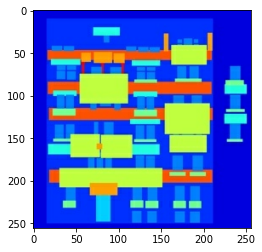

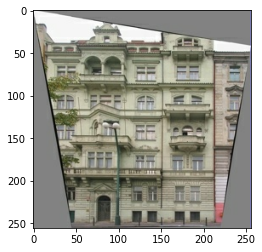

In [5]:
inp, re = load(PATH+'train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [6]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image, real_image

In [7]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0) # of shape [2, height, width, channel]
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHTS, IMG_WIDTH, 3])
    return cropped_image[0], cropped_image[1]

In [8]:
# normalize the image to [-1 ,1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

In [9]:
@tf.function
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)
    
    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)
    
    if tf.random.uniform(()) > 0.5:
        # random flipping
        input_image = tf.image.random_flip_left_right(input_image)
        real_image = tf.image.random_flip_left_right(real_image)
        
    return input_image, real_image

As you can see in the images below that they are going through random jittering. Random jittering as described in the paper is to:
- Resize an image to bigger height and width
- Randomly crop to the target size
- Randomly flip the image horizontally

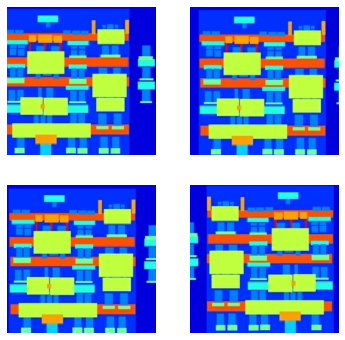

In [10]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()

In [11]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [12]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHTS, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

## Input pipeline

In [13]:
train_dataset = tf.data.Dataset.list_files(PATH + 'train/*.jpg')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(PATH + 'test/*.jpg')
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the Generator

- The architecture of generator is a modified U-Net.
- Each block in the encoder is (Conv2D -> BatchNorm -> LeakyRelu)
- Each block in the decoder is (Conv2DTranspose -> BatchNorm -> Dropout(applied to the first 3 blocks) -> Relu)
- There are skip connections between the encoder and decoder (as in U-Net)

In [14]:
OUTPUT_CHANNELS = 3

In [15]:
def downsample(filters, size, apply_batchnorm=True):
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=(2,2), padding='same',
                               kernel_initializer=tf.keras.initializers.RandomNormal(0.0, 0.02),
                               use_bias=False))
    if apply_batchnorm: result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU(0.3))
    return result

In [16]:
down_model = downsample(3, 4, True)
down_result = down_model(tf.expand_dims(inp, 0))
down_result.shape

TensorShape([1, 128, 128, 3])

In [17]:
def upsample(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=(2,2), padding='same',
                                        kernel_initializer=tf.keras.initializers.RandomNormal(0.0, 0.02),
                                        use_bias=False)
    )
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout: result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [18]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
up_result.shape

TensorShape([1, 256, 256, 3])

In [19]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    
    # Total 8 downsampling layer
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # [None, 128, 128, 64]
        downsample(128, 4, apply_batchnorm=True), # [None, 64, 64, 128]
        downsample(256, 4, apply_batchnorm=True), # [None, 32, 32, 256]
        downsample(512, 4, apply_batchnorm=True), # [None, 16, 16, 512]
        downsample(512, 4, apply_batchnorm=True), # [None, 8, 8, 512]
        downsample(512, 4, apply_batchnorm=True), # [None, 4, 4, 512]
        downsample(512, 4, apply_batchnorm=True), # [None, 2, 2, 512]
        downsample(512, 4, apply_batchnorm=True)  # [None, 1, 1, 512]
    ]
    
    # Total 7 upsampling layers
    up_stack = [
        upsample(1024, 4, apply_dropout=True), # [None, 2, 2, 1024]
        upsample(1024, 4, apply_dropout=True), # [None, 4, 4, 1024]
        upsample(1024, 4, apply_dropout=True), # [None, 8, 8, 1024]
        upsample(1024, 4, apply_dropout=False),# [None, 16, 16, 1024]
        upsample(512, 4, apply_dropout=False), # [None, 32, 32, 512]
        upsample(256, 4, apply_dropout=False), # [None, 64, 64, 256]
        upsample(128, 4, apply_dropout=False)  # [None, 128, 128, 128]
    ]
    
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=(2,2), padding='same',
                                           kernel_initializer=tf.keras.initializers.RandomNormal(0.0, 0.02),
                                           activation='tanh') # [None, 256, 256, 3]
    
    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    # downsampling final x -> [..., 1, 1, ...]
        
    skips = reversed(skips[:-1]) # from [..., 2, 2, ...] to [..., 128, 128, ...]
    
    # upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate(axis=-1)([x, skip])
        
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

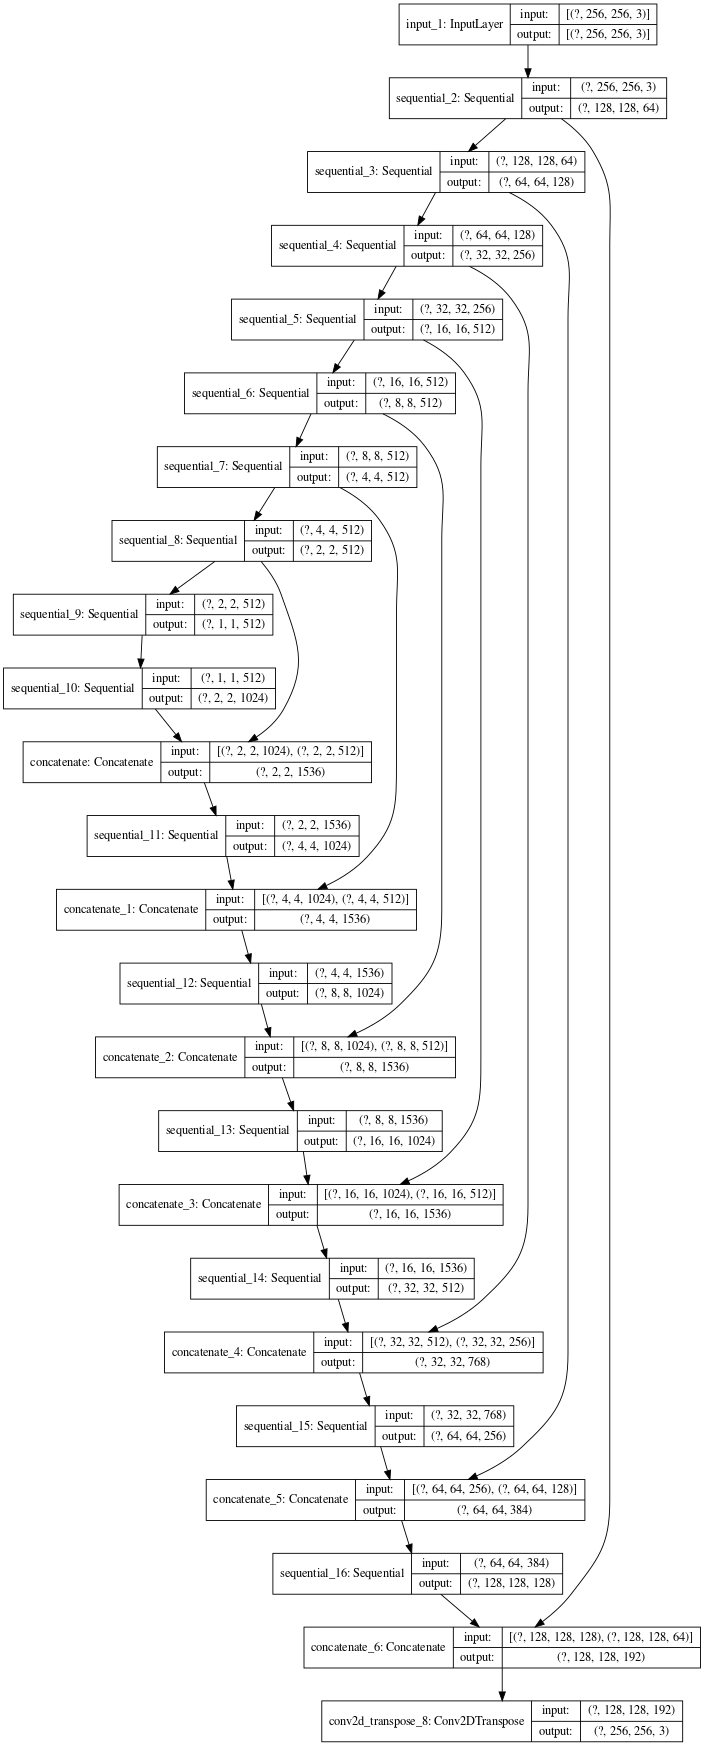

In [20]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


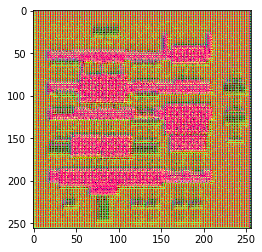

In [21]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0])

__Generator loss:__
- It is a sigmoid cross entropy loss of the generated images and an array of ones.
- The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calcualte the total generator $loss = gan\_loss + \lambda \cdot l1\_loss$, where $\lambda$ = 100. This value was decided by the author of the paper.

In [22]:
LAMBDA = 100

In [23]:
# When `from_logits=True`, it will apply sigmoid function on logits first, then apply crossentropy.
# Why use sigmoid?
# Cause if we use softmax, other predictions will affect the output, while sigmoid will not.
######
#   For brevity, let `x = logits`, `z = labels`.  The logistic loss is
#         z * -log(sigmoid(x)) + (1 - z) * -log(1 - sigmoid(x))
#       = z * -log(1 / (1 + exp(-x))) + (1 - z) * -log(exp(-x) / (1 + exp(-x)))
#       = z * log(1 + exp(-x)) + (1 - z) * (-log(exp(-x)) + log(1 + exp(-x)))
#       = z * log(1 + exp(-x)) + (1 - z) * (x + log(1 + exp(-x))
#       = (1 - z) * x + log(1 + exp(-x))
#       = x - x * z + log(1 + exp(-x))
#   For x < 0, to avoid overflow in exp(-x), we reformulate the above
#         x - x * z + log(1 + exp(-x))
#       = log(exp(x)) - x * z + log(1 + exp(-x))
#       = - x * z + log(1 + exp(x))
#   Hence, to ensure stability and avoid overflow, the implementation uses this
#   equivalent formulation
#       max(x, 0) - x * z + log(1 + exp(-abs(x)))
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
def generator_loss(disc_generated_output, gen_output, target):
    """
    Args:
        disc_generated_output: of shape [None, 30, 30, 1]
        gen_output: of shape [None, 256, 256, 3]
        target: of shape [None, 256, 256, 3]
    """
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss

Generator training procedure:

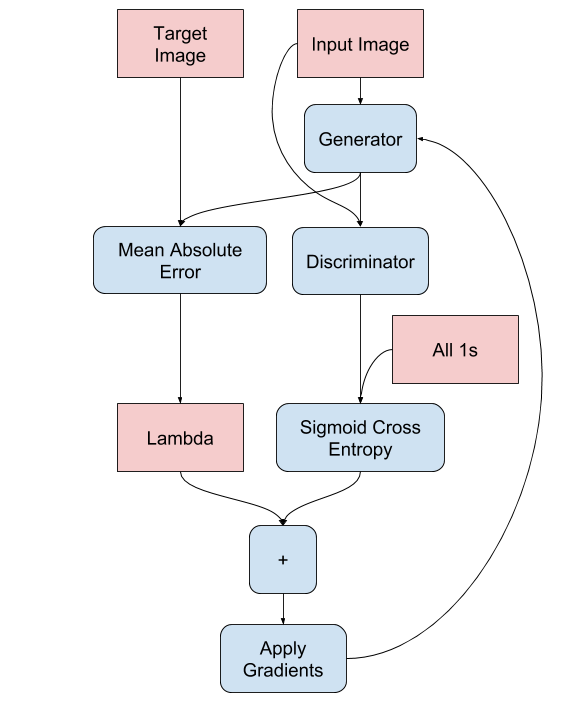

## Build the Discriminator

- The Discriminator is a PatchGAN.
- Each block in the discriminator is (Conv2D -> BatchNorm -> LeakyReLU)
- The shape of the output after the last layer is (batch_size, 30, 30, 1)
- Each 30 x 30 patch of the output classifies a 70 x 70 portion of the input image (such an architecture is called a PattchGAN)
- Discriminator receives 2 inputs
    - Input image and the target image, which it should classify as real.
    - Input image and the generated image (output of generator), which is should classify as fake.
    - We concatenate these 2 inputs together in the code (`tf.concate([inp, tar], axis=-1)`)

In [25]:
def Discriminator():
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    
    x = tf.keras.layers.Concatenate(axis=-1)([inp, tar]) # [None, 256, 256, channels*2]
    
    down1 = downsample(64, 4, apply_batchnorm=False)(x)     # [None, 128, 128, 64]
    down2 = downsample(128, 4, apply_batchnorm=True)(down1) # [None, 64, 64, 128]
    down3 = downsample(256, 4, apply_batchnorm=True)(down2) # [None, 32, 32, 256]
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D(padding=((1,1), (1,1)))(down3) # [None, 34, 34, 256]
    conv = tf.keras.layers.Conv2D(512, 4, strides=(1,1),
                                  kernel_initializer=tf.keras.initializers.RandomNormal(0.0, 0.02),
                                  use_bias=False)(zero_pad1) # [None, 31, 31, 512]
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU(0.3)(batchnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D(padding=((1,1), (1,1)))(leaky_relu) # [None, 33, 33, 512]
    
    last = tf.keras.layers.Conv2D(1, 4, strides=(1,1),
                                  kernel_initializer=tf.keras.initializers.RandomNormal(0.0, 0.02))(zero_pad2)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

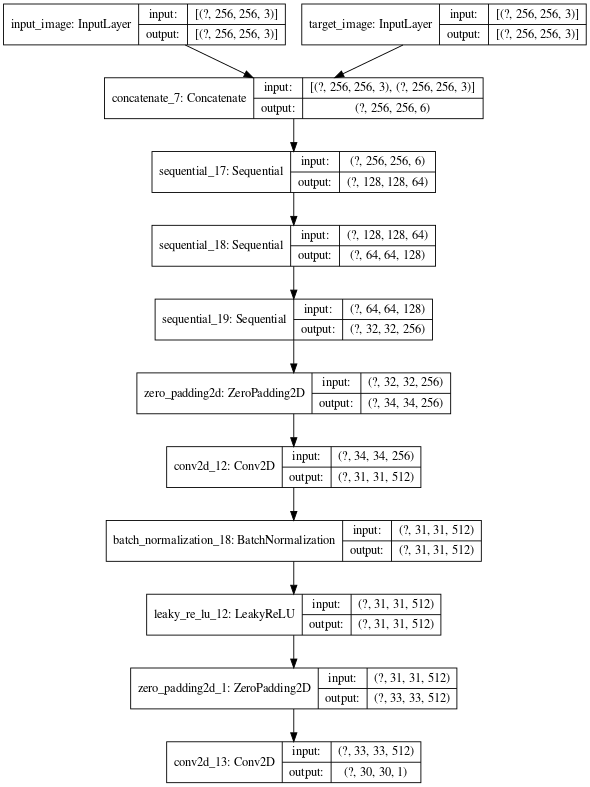

In [26]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

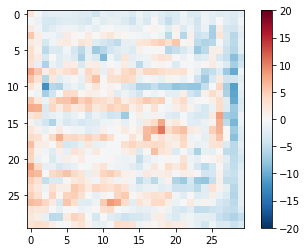

In [27]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., 0], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

__Discriminator loss:__
- The discriminator loss function takes 2 inputs: __real images__, __generated images__
- real_loss is a sigmoid cross entropy loss of the __real images__ and an __array of ones (since these are the real images)__
- generated_loss is a sigmoid cross entropy loss of the __generated images__ and an __array of zeros(since these are the fake images)__
- Then the total_loss is the sum of real_loss and generated_loss

In [28]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

Discriminator training procudure:

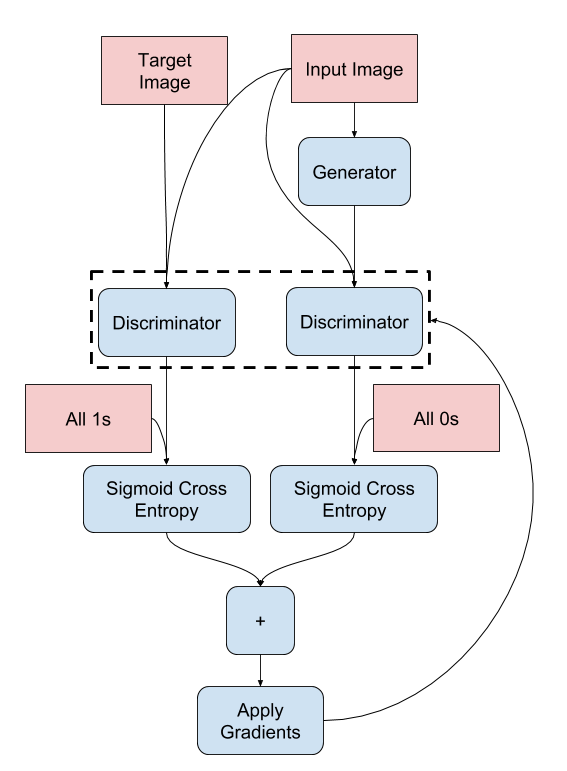

## Define the optimizers and Checkpoint-saver

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [30]:
checkpoint_dir = './training_checkpoints'
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                           discriminator_optimizer=discriminator_optimizer,
                           generator=generator,
                           discriminator=discriminator)
checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=5)

## Generate Images

Note: The `training=True` is intentional here since we want the batch statistics while running the model on the test dataset. If we use training=False, we will get the accumulated statistics learned from the training dataset (which we don't want)

In [31]:
def generate_images(generator, test_input, tar):
    generated_images = generator(test_input, training=True)
    plt.figure(figsize=(15,15))
    
    display_list = [test_input[0], tar[0], generated_images[0]]
    titles = ['Input Image', 'Ground Truth', 'Generated Image']
    
    for i, (image, title) in enumerate(zip(display_list, titles)):
        plt.subplot(1, 3, i+1)
        plt.title(title)
        # getting the pixel values between [0, 1] to plot it
        plt.imshow(image * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

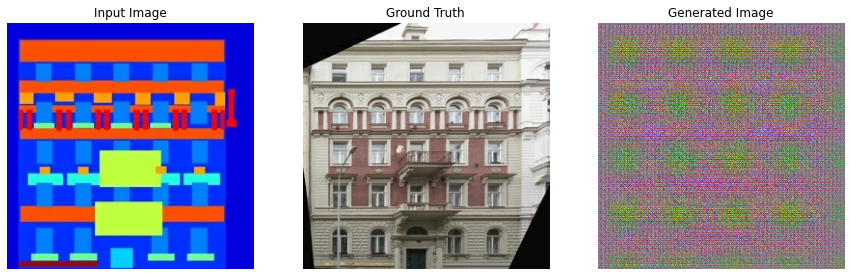

In [32]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

## Training

In [33]:
EPOCHS = 150

In [34]:
import datetime
log_dir = 'logs/'

summary_writer = tf.summary.create_file_writer(log_dir + 'fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [39]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([gen_output, target], training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
       
    return {
        "gen_total_loss": gen_total_loss,
        "gen_gan_loss": gen_gan_loss,
        "gen_l1_loss": gen_l1_loss,
        "disc_loss": disc_loss
    }

In [40]:
def fit(train_dataset, epochs, test_dataset):
    
    # Tracking losses
    gen_total_loss = tf.keras.metrics.Mean(name='gen_total_loss')
    gen_gan_loss = tf.keras.metrics.Mean(name='gen_gan_loss')
    gen_l1_loss = tf.keras.metrics.Mean(name='gen_l1_loss')
    disc_loss = tf.keras.metrics.Mean(name='disc_loss')
    
    # each epoch
    for epoch in range(epochs):
        start = time.time()
        
        display.clear_output(wait=True)
        
        # Plot the one example from test_dataset to visualize the training progress
        for input_batch, target_batch in test_dataset.take(1):
            generate_images(generator, input_batch, target_batch)

        # Train
        print('Epoch: {:d}'.format(epoch))
        for batch_id, (input_images, target_images) in train_dataset.enumerate():
            print('.', end='')
            if (batch_id + 1) % 100 == 0: print()
            losses = train_step(input_images, target_images)
            # update losses tracking
            gen_total_loss.update_state(losses["gen_total_loss"])
            gen_gan_loss.update_state(losses["gen_gan_loss"])
            gen_l1_loss.update_state(losses["gen_l1_loss"])
            disc_loss.update_state(losses["disc_loss"])
        print()
        
        # logging losses tracking to tensorboard
        with summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss.result(), step=epoch)
            tf.summary.scalar('gen_gan_loss', gen_gan_loss.result(), step=epoch)
            tf.summary.scalar('gen_l1_loss', gen_l1_loss.result(), step=epoch)
            tf.summary.scalar('disc_loss', disc_loss.result(), step=epoch)
        # reset losses tracking
        gen_total_loss.reset_states()
        gen_gan_loss.reset_states()
        gen_l1_loss.reset_states()
        disc_loss.reset_states()
        
        # Saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint_manager.save()
            
        print('Time taken for epoch {} is {} sec\n'.format(epoch+1, time.time()-start))
        
    checkpoint_manager.save()

In [37]:
%load_ext tensorboard
%tensorboard --logdir {log_dir} --port 9999

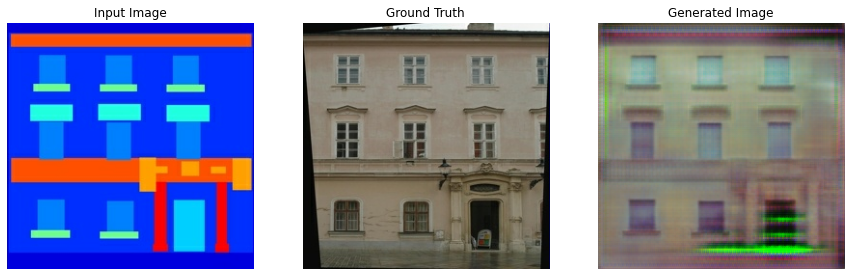

Epoch: 149
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Time taken for epoch 150 is 73.58111953735352 sec



In [41]:
fit(train_dataset, EPOCHS, test_dataset)